# Comparison of the networks for all time steps

In [191]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import networkx as nx
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tqdm
import time
from upsetplot import from_contents, UpSet
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from IPython.core.display import SVG
import gseapy
from gseapy.plot import barplot, dotplot
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Import custom libraries
import pcst_utils_2 as pcst

In [31]:
# Reload modules in case of modifications
reload(pcst)

<module 'pcst_utils_2' from '/home/braunger/masterthesis/python_code/PCST/pcst_utils_2.py'>

In [3]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"
fig_dir = "/home/braunger/masterthesis/save/figures/pcst/"

# Significant TFs

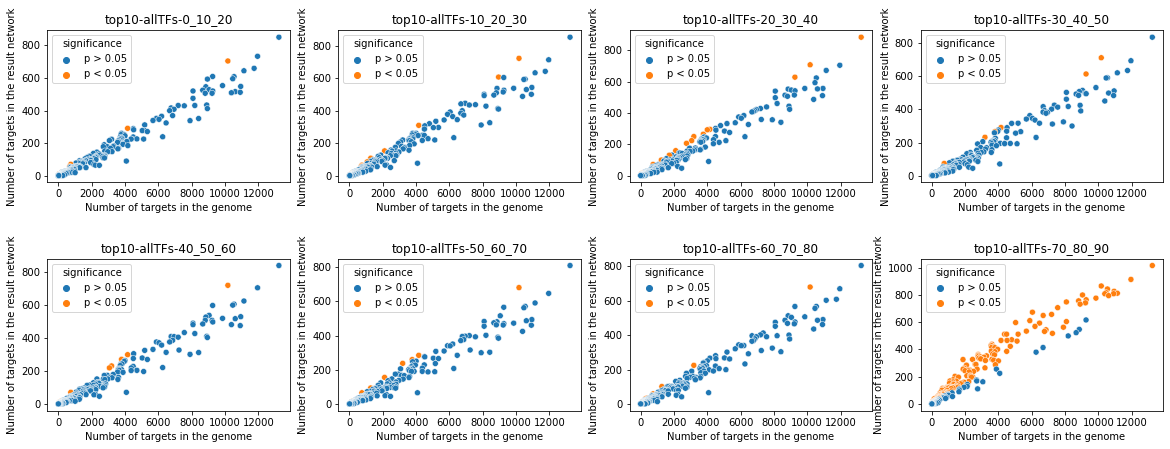

In [4]:
net_dir = pcst.get_net_dir_all_stages(save_dir, "allTFs", "top10")
net_stats, target_counts = pcst.compare_networks(net_dir, data_dir, fig_dir, save_dir)

The last model includes much more significant TFs than the models for the earlier time steps, meaning that many of the included TFs target a lot of the genes that are differentially expressed between the 80s and 90s group.

# General network statistics


In [5]:
net_stats.iloc[:, 0:8]

,n_nodes,n_edges,n_prized_nodes,n_Steiner_nodes,n_TFs,n_incl_TFs,n_prized_TFs,n_significant_TFs
top10-allTFs-0_10_20,3658,90827,2693,965,378,295,183,6
top10-allTFs-10_20_30,3672,89360,2678,994,375,298,195,13
top10-allTFs-20_30_40,3717,90167,2696,1021,378,299,191,24
top10-allTFs-30_40_50,3674,91445,2695,979,370,298,208,8
top10-allTFs-40_50_60,3678,89162,2677,1001,373,293,192,9
top10-allTFs-50_60_70,3727,88799,2672,1055,376,290,183,9
top10-allTFs-60_70_80,3663,89580,2689,974,390,304,199,10
top10-allTFs-70_80_90,3763,109524,2743,1020,403,321,217,182


All of the networks consist of around 3700 nodes of which around 1000 are Steiner node. Around 300 TFs are included in each of the networks.

# Intersections of the TFs

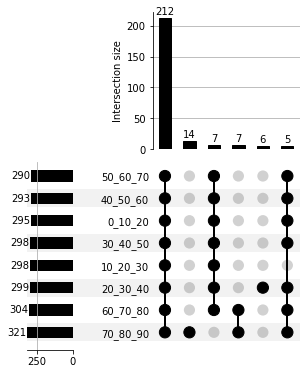

In [6]:
incl_TFs = [[tf[:-4] for tf in net_stats.iloc[net, 8]] for net in range(8)]

intersections = from_contents({'0_10_20': incl_TFs[0], 
                               '10_20_30': incl_TFs[1],
                               '20_30_40': incl_TFs[2],
                               '30_40_50': incl_TFs[3], 
                               '40_50_60': incl_TFs[4],
                               '50_60_70': incl_TFs[5],
                               '60_70_80': incl_TFs[6],
                               '70_80_90': incl_TFs[7]})
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 5).plot()

plt.savefig(fig_dir+'intersections_allTFs_top10.png')

Most of the TFs (212 out of the 300 per network) occur in each network.

# Analyses of the TFs that occur in all 8 networks

## Numbers of DE targets per net

In [7]:
# Get number of DE targets for the TFs in each of the networks
targets_shared_TFs = pd.DataFrame(index = set.intersection(*map(set,incl_TFs)))

for index, (name, df) in enumerate(target_counts.items()):
    df.index = df.index.str.replace("_tr0", "")
    if index == 0: 
        df = df[['protein1_all_targets', 'protein1_incl_targets']]
        df.columns = ['n_targets', name.split("-")[2]]
    else:
        df = df[['protein1_incl_targets']]
        df.columns = [name.split("-")[2]]
    targets_shared_TFs = targets_shared_TFs.join(df)
    
targets_percent = targets_shared_TFs.iloc[:,1:].div(targets_shared_TFs.n_targets, axis=0)
targets_shared_TFs.head()

,n_targets,0_10_20,10_20_30,20_30_40,30_40_50,40_50_60,50_60_70,60_70_80,70_80_90
BRD7,109,7,12,11,11,14,10,10,11
CENPA,81,3,4,3,2,3,3,4,6
MAX,8902,434,413,444,425,410,391,401,732
IRF3,134,6,7,6,4,7,7,8,9
DDX5,3573,165,157,165,141,149,155,152,388


## TF correlations 

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

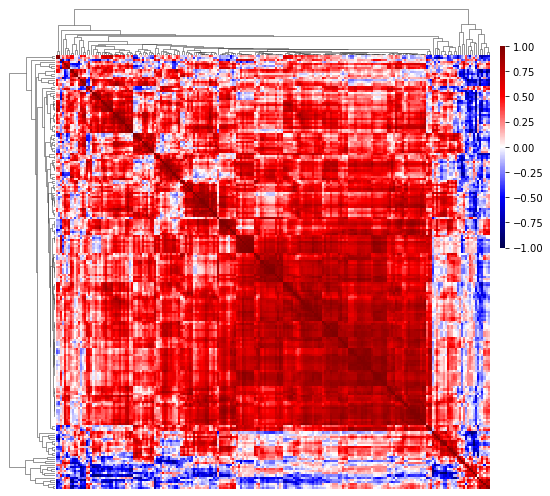

In [176]:
# Correlation between the TFs
corr_TFs = targets_shared_TFs.iloc[:, 1:].T.corr(method = "spearman")
plt.figure()
sns.clustermap(corr_TFs,
               method='average',
               metric='cosine',
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False,
               cmap='seismic', cbar_pos=(1, 0.5, 0.01, .4),
               dendrogram_ratio=(.1, .1),
               vmin = -1, vmax = 1, figsize=(7,7))
plt.show()

The heatmap is clearly clustered into two distinct groups of TFs <br> --> analyse which TFs are in the small cluster and how their trajectories differs from the others

## Analyses of the two high-level clusters

In [40]:
clustering = AgglomerativeClustering(n_clusters=2, affinity='cosine', linkage='average').fit(targets_shared_TFs.iloc[:, 1:].T.corr(method = "spearman"))
print('Number of TFs in cluster 0 = '+str(np.sum(clustering.labels_==0)))
print('Number of TFs in cluster 1 = '+str(np.sum(clustering.labels_==1)))

Number of TFs in cluster 0 = 16
Number of TFs in cluster 1 = 196


In [41]:
# TFs in the small cluster
TF_clusters = pd.DataFrame({'TF': targets_shared_TFs.iloc[:, 1:].index, 
                            'cluster': clustering.labels_})
selected_TFs = TF_clusters[TF_clusters['cluster'] == 0].TF.tolist()
selected_TFs

['FOXO3',
 'HOXB13',
 'GATA4',
 'HNF1B',
 'NR3C1',
 'TCF4',
 'AR',
 'BATF',
 'ONECUT1',
 'GATA3',
 'GLIS1',
 'HDAC6',
 'PCGF2',
 'UBN1',
 'IRF2',
 'MTA3']

Many of these TFs seem to have functions related to aging: 
<br>
**FOXO3**: "The prospect of optimizing FoxO3 activity in humans to increase lifespan and reduce age-related diseases represents an exciting avenue of clinical investigation. Research strategies directed at developing therapeutic agents that target FoxO3, its gene and proteins in the pathway(s) FoxO3 regulates should be encouraged and supported." (https://www.karger.com/Article/Fulltext/375235) <br>
**PCGF2**: "maintain the transcription repression of genes involved in embryogenesis, cell cycles, and tumorigenesis. This protein was shown to act as a negative regulator of transcription and has tumor suppressor activity" (https://www.genecards.org/cgi-bin/carddisp.pl?gene=PCGF2) <br>
**UBN1**: "Acts as a novel regulator of senescence" (https://www.genecards.org/cgi-bin/carddisp.pl?gene=UBN1) <br>
**GATA4**: "GATA4 accumulation in aging tissues may contribute to age-related diseases including cancer." (https://aacrjournals.org/cancerdiscovery/article/5/12/OF19/5306/GATA4-Is-a-Critical-Regulator-of-Senescence-and)<br>
**HOXB13**: "essential for vertebrate embryonic development. This gene has been implicated to play a role in fetal skin development and cutaneous regeneration" (https://www.genecards.org/cgi-bin/carddisp.pl?gene=HOXB13)<br>

**HDAC6**: is this even a transcription factor?

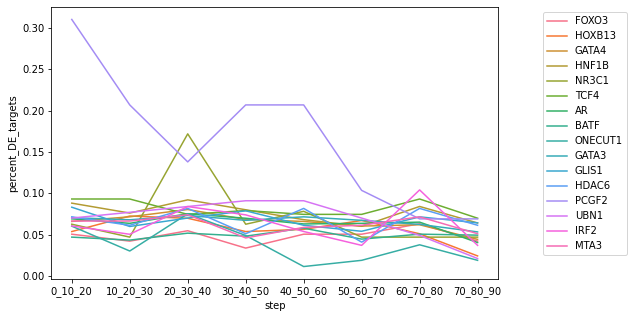

In [47]:
# plot number of targets for the selected TFs
targets_selection = targets_percent[targets_percent.index.isin(selected_TFs)]
targets_selection.reset_index(inplace=True)
                                    
targets_selection = pd.melt(targets_selection, id_vars = ['index'],
       var_name='step', value_name = 'percent_DE_targets')
targets_selection.columns = ['TF', 'step', 'percent_DE_targets']

plt.figure(figsize = (8, 5))
g = sns.lineplot(x='step', y='percent_DE_targets', hue='TF', 
             data=targets_selection)
g.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [48]:
targets_percent.reset_index(inplace=True)

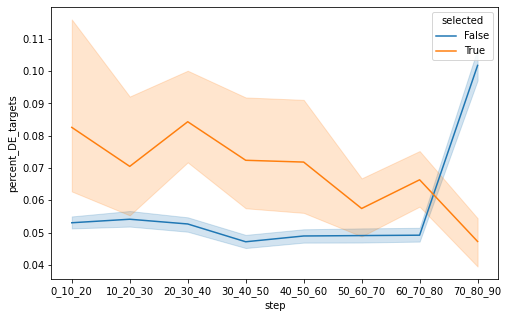

In [49]:
# plot trajectory of the number of targets in the two clusters
targets_long = pd.melt(targets_percent, id_vars = ['index'],
       var_name='step', value_name = 'percent_DE_targets')
targets_long.columns = ['TF', 'step', 'percent_DE_targets']
targets_long['selected'] = np.where(targets_long['TF'].isin(selected_TFs), 'True', 'False')

plt.figure(figsize = (8, 5))
sns.lineplot(data=targets_long,
             x='step', y='percent_DE_targets',
             hue="selected")

plt.show()

Possible explanations: most TFs (blue line) have the highest number of DE targets in the last model, which could be due to the opening and higher accessibility of the chromatin during aging such that genes that are not specific to aging, but targeted by many of the common TFs get differentially expressed. The trend for the orange line including only a small number of TFs (15) however is inversed, which means that they have less DE targets during aging. One reason for that could be that early during aging only genes that play a role in development/aging are differentially expressed, whereas in the last model many non-aging-specific genes are DE, so the majority of the TFs (blue) has more targets there, whereas the age-specific TFs (orange) have less targets in the last model???
<br> Expression of the 15 TFs from the orange cluster (only 11 are shown since two of them have TPM < 0.1 for all time points and 2 are not included in the RNAseq data):

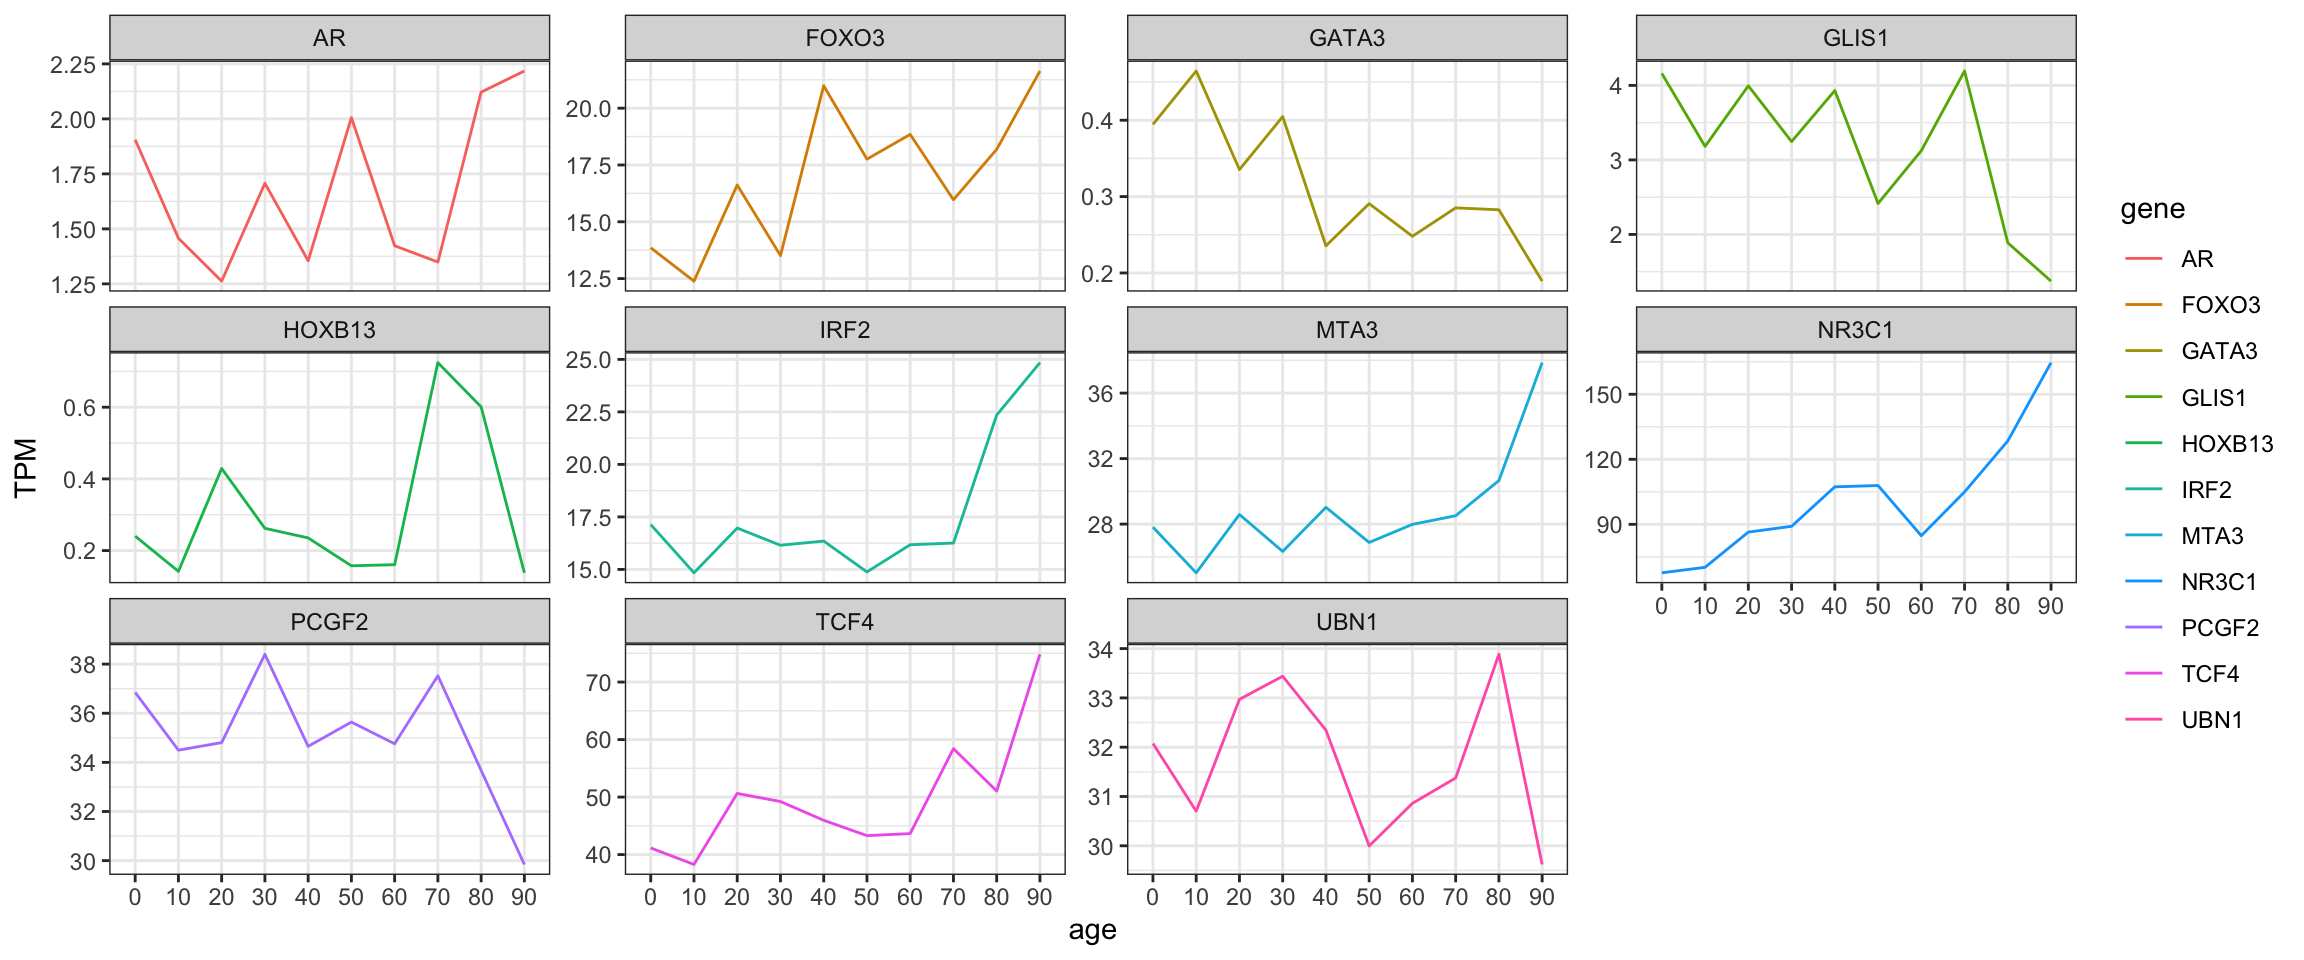

In [30]:
Image(fig_dir+"expr_selected_TFs.png",width=900)

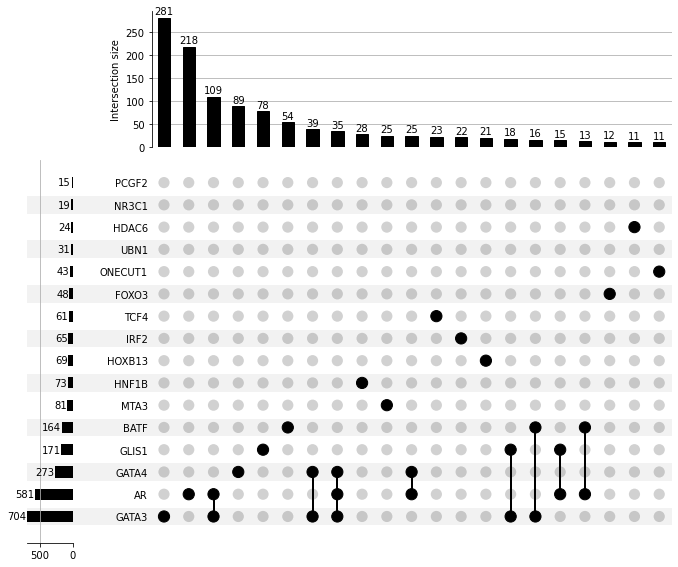

In [263]:
# How many targets are shared between the TFs in the small (orange) cluster?
tf_targets = pd.read_csv(data_dir + 'tf_data/tf-target-information.txt', sep = '\t')
tf_targets = tf_targets[['TF', 'target']].drop_duplicates()
de_genes = pd.read_csv(data_dir+'de_data/fc_top10.csv')
tf_targets_selected_DE = tf_targets[(tf_targets['TF'].isin(selected_TFs)) & (tf_targets['target'].isin(de_genes['gene']))]

targets_dict = {}
for TF in selected_TFs:
    targets_dict[TF] = tf_targets_selected_DE.loc[tf_targets_selected_DE['TF'] == TF, 'target'].tolist()
    
intersections = from_contents(targets_dict)
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 10).plot()

Around 30-45% of the DE targets of TFs with many targets are not targeted by other TFs in this cluster and more than half of the targets are shared with other TFs.

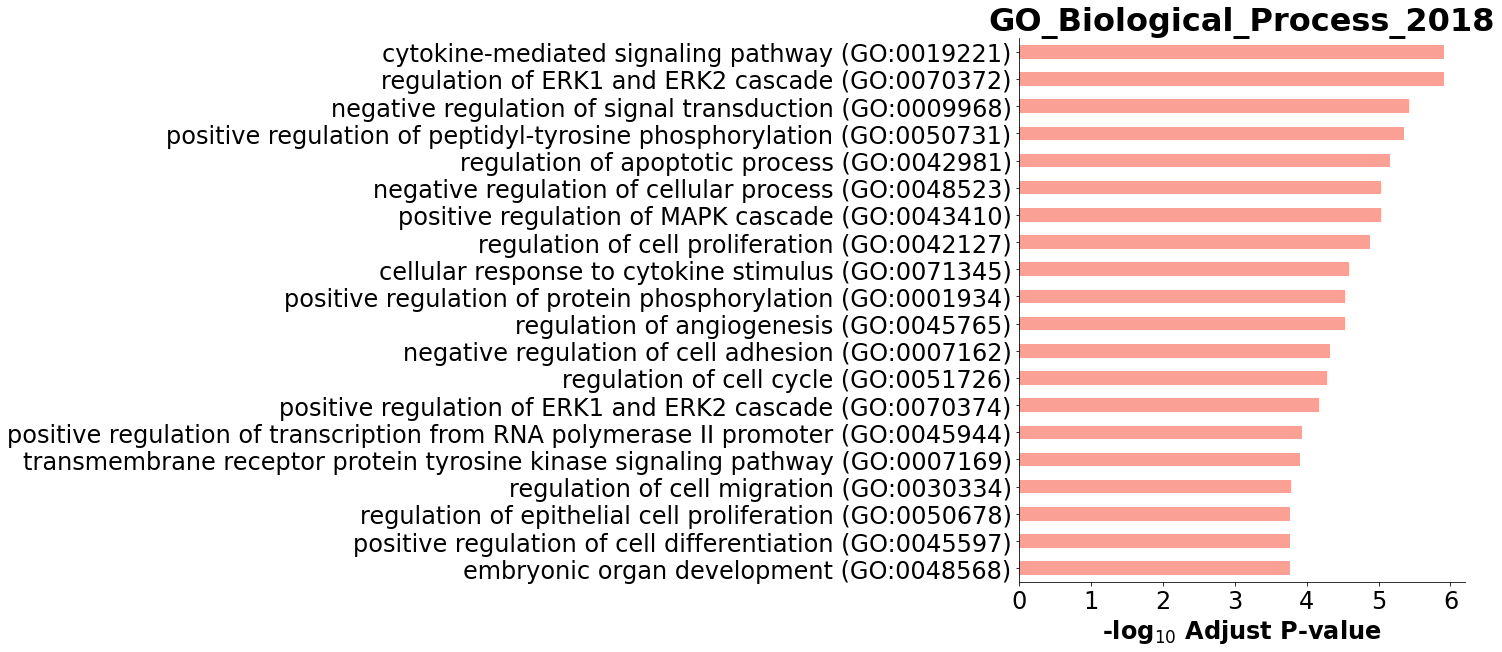

In [265]:
# GSEA on the targets of the selected TFs
enr = gseapy.enrichr(gene_list=tf_targets_selected_DE['target'].unique().tolist(), 
                     gene_sets='GO_Biological_Process_2018', 
                     description='small-cluster', outdir=save_dir+'GO_small_cluster', format='png',
                     verbose=False)
# Visualize results
#enr.results.head(5)
barplot(enr.res2d, title='GO_Biological_Process_2018',
        cutoff=0.01, top_term=20, figsize=(8, 10), color='salmon')

Those pathways are probably in general enriched in the DE genes (when doing a enrichment analyses on all targets of these 16 TFs no significant pathways were found)

/home/braunger/miniconda3/envs/pcst/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 432x288 with 0 Axes>

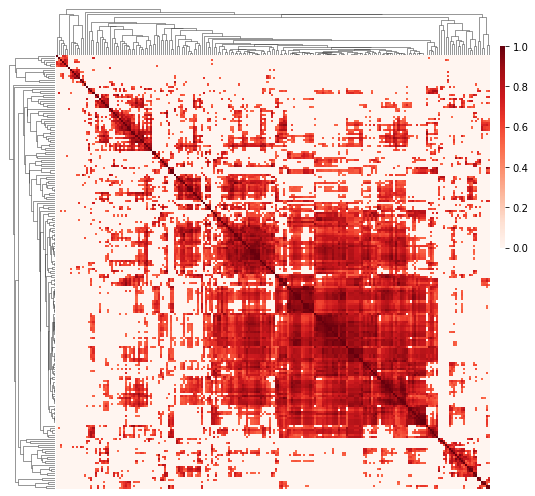

In [256]:
# Threshold correlation matrix
corr_TFs_0 = corr_TFs.copy()
corr_TFs_0[corr_TFs_0 < 0.5] = 0

plt.figure()
sns.clustermap(corr_TFs_0,
               method='average',
               metric='cosine',
               row_cluster=True, col_cluster=True,
               xticklabels=False, yticklabels=False,
               cmap='Reds', cbar_pos=(1, 0.5, 0.01, .4),
               dendrogram_ratio=(.1, .1),
               vmin = 0, vmax = 1, figsize=(7,7))
plt.show()

In [207]:
# Create network
corr_long = pd.melt(corr_TFs_0.reset_index(), id_vars='index')
corr_long = corr_long[(corr_long['value'] > 0) & (corr_long['index'] != corr_long['variable'])]
corr_long.columns = ['protein1', 'protein2', 'corr']
corr_long

network = nx.from_pandas_edgelist(corr_long, 'protein1', 'protein2', 'corr')
# add clusters as node attributes
clusters = {TF: TF_clusters.loc[TF_clusters['TF'] == TF, 'cluster'].tolist() for TF in list(network.nodes())}
nx.set_node_attributes(network, clusters, name='cluster')
oi.output_networkx_graph_as_interactive_html(network, filename=save_dir + "TF_corr_0.5.html")

PosixPath('/home/braunger/masterthesis/save/pcst/TF_corr_0.5.html')

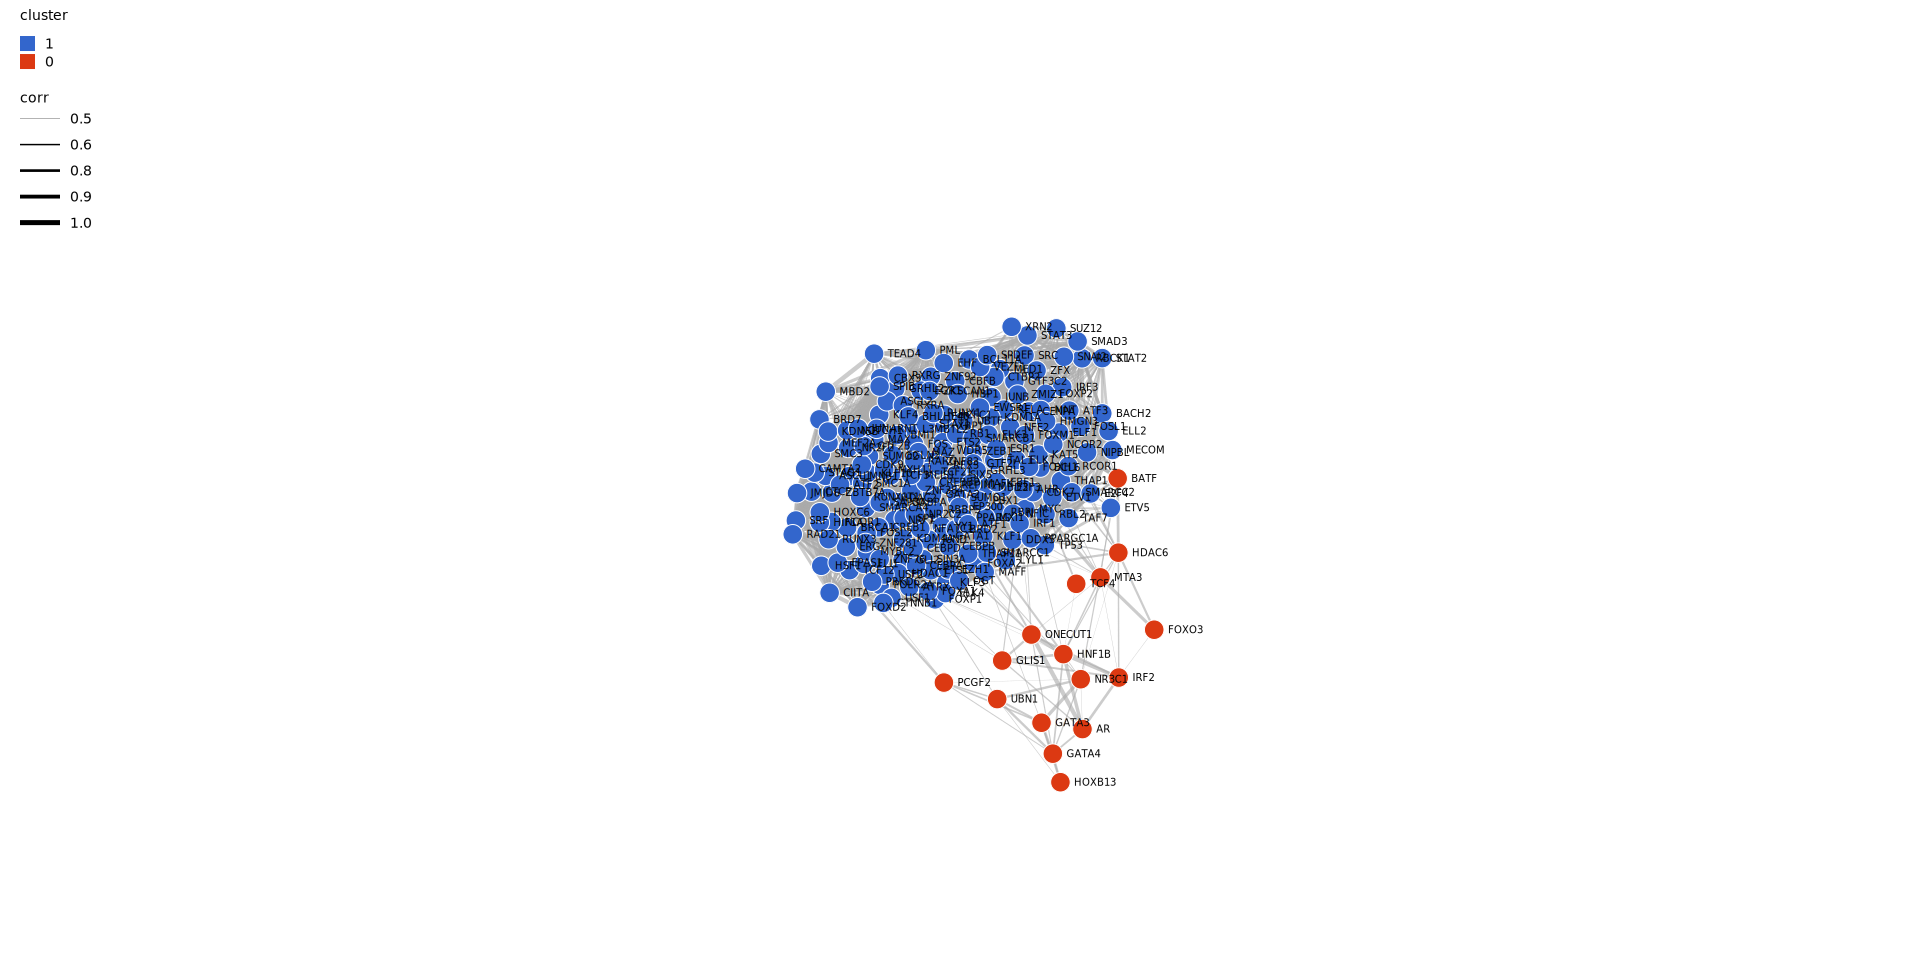

In [273]:
# network image created from the interactive html file
SVG(fig_dir+"net_sharedTFs_top10.svg")

## Analyses of the subclusters of the big cluster

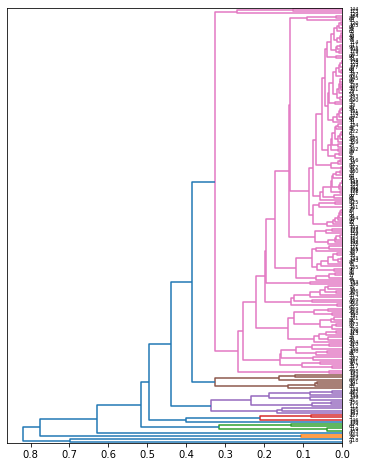

In [269]:
corr_big = corr_TFs.loc[~corr_TFs.index.isin(selected_TFs), ~corr_TFs.index.isin(selected_TFs)]
dend = linkage(corr_big, 
               method='average', metric='cosine')
plt.figure(figsize = (6, 8))
dendrogram(dend, orientation = "left", color_threshold = 0.35)
plt.show()

In [272]:
TF_clusters = pd.DataFrame({'TF': corr_big.index, 
                            'cluster': fcluster(dend, 0.35, criterion = 'distance')})
TF_clusters['cluster'].value_counts()

9     165
7      11
8       7
4       4
5       3
3       2
10      1
1       1
2       1
6       1
Name: cluster, dtype: int64

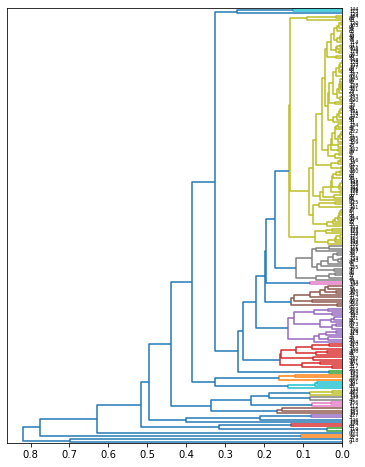

In [228]:
corr_big = corr_TFs.loc[~corr_TFs.index.isin(selected_TFs), ~corr_TFs.index.isin(selected_TFs)]
dend = linkage(corr_big, 
               method='average', metric='cosine')
plt.figure(figsize = (6, 8))
dendrogram(dend, orientation = "left", color_threshold = 0.17)
plt.show()

In [229]:
TF_clusters = pd.DataFrame({'TF': corr_big.index, 
                            'cluster': fcluster(dend, 0.17, criterion = 'distance')})

In [231]:
# Create network
corr_big[corr_big < 0.8] = 0
corr_long = pd.melt(corr_big.reset_index(), id_vars='index')
corr_long = corr_long[(corr_long['value'] > 0) & (corr_long['index'] != corr_long['variable'])]
corr_long.columns = ['protein1', 'protein2', 'corr']
corr_long

network = nx.from_pandas_edgelist(corr_long, 'protein1', 'protein2', 'corr')
# add clusters as node attributes
clusters_dict = {TF: TF_clusters.loc[TF_clusters['TF'] == TF, 'cluster'].tolist() for TF in list(network.nodes())}
nx.set_node_attributes(network, clusters_dict, name='cluster')
oi.output_networkx_graph_as_interactive_html(network, filename=save_dir + "TF_corr_big_0.8.html")

PosixPath('/home/braunger/masterthesis/save/pcst/TF_corr_big_0.8.html')

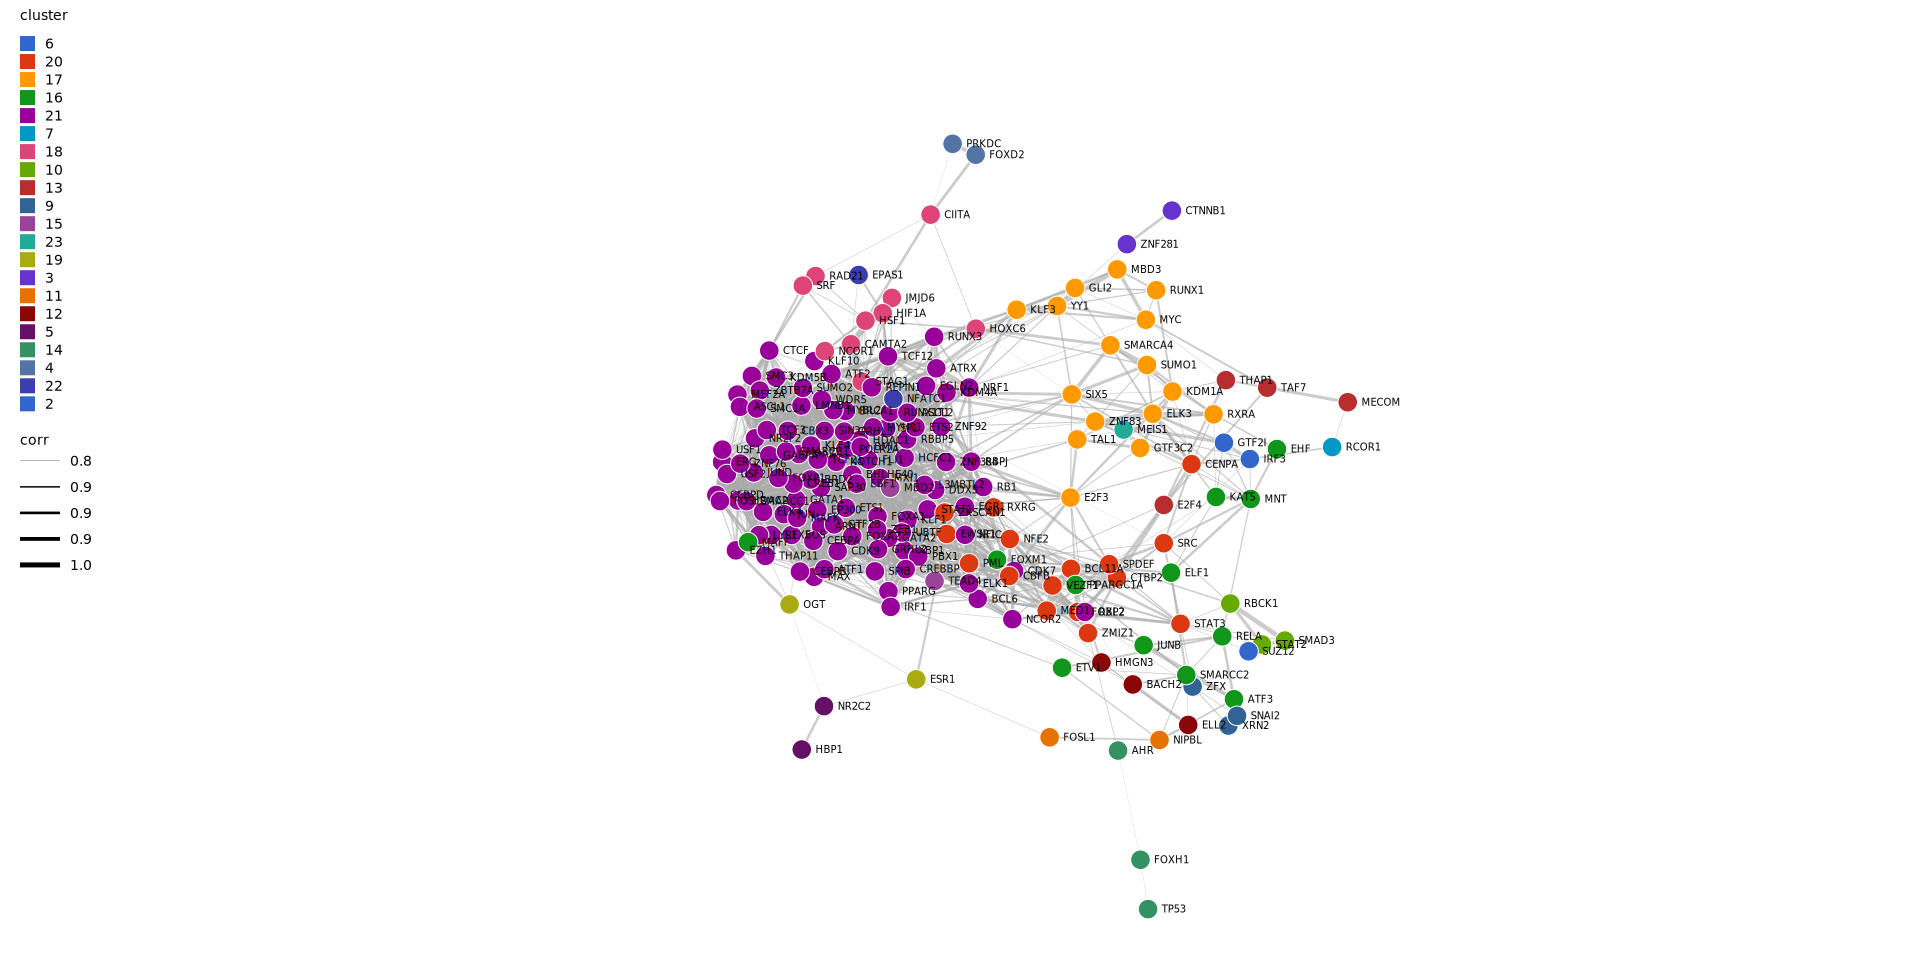

In [232]:
# visualization of the network
SVG(fig_dir+"net_big_cluster.svg")

In [260]:
TF_clusters.loc[TF_clusters['cluster'] == 17,'TF'].tolist()

19        TAL1
20        GLI2
28      GTF3C2
37         MYC
48        KLF3
51       SUMO1
85        SIX5
92       ZNF83
104      RUNX1
113       MBD3
126        YY1
139      KDM1A
150       RXRA
168       E2F3
173       ELK3
181    SMARCA4
Name: TF, dtype: object

# Analyses of the TFs that are specific to the last two networks

In [46]:
TFs_old = set.union(*map(set,incl_TFs[6:8])).difference(*map(set,incl_TFs[:6]))
TFs_old

{'BCL3',
 'DLX4',
 'ELF2',
 'ERF',
 'GATAD1',
 'HMGN1',
 'ICE1',
 'IKZF1',
 'MAFG',
 'PAX5',
 'SMAD2',
 'SNAPC5',
 'SOX9',
 'SUPT20H',
 'TAF1',
 'TP63',
 'TRRAP',
 'ZBED4',
 'ZBTB10',
 'ZNF266',
 'ZNF84'}

In [233]:
# how many DE targets do these TFs share
de_genes_old = de_genes[de_genes['transition'] == "fc_80_90"]
tf_targets_old = tf_targets[(tf_targets['TF'].isin(TFs_old)) & (tf_targets['target'].isin(de_genes_old['gene']))]

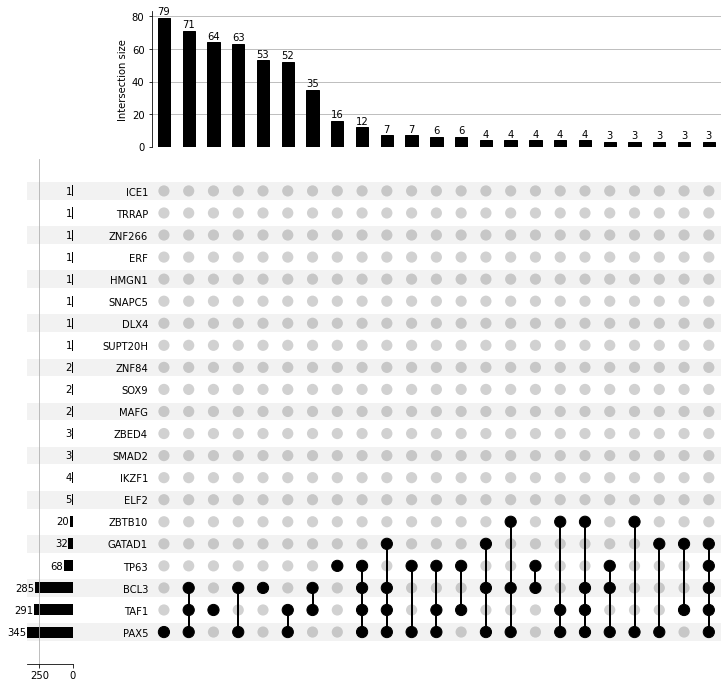

In [82]:
targets_dict = {}
for TF in TFs_old:
    targets_dict[TF] = tf_targets_old.loc[tf_targets_old['TF'] == TF, 'target'].tolist()
    
intersections = from_contents(targets_dict)
upset = UpSet(intersections, subset_size='count', show_counts = True,  
              sort_by="cardinality", min_subset_size = 3).plot()

In [87]:
# get genes that are targeted by the old-specific TFs, but not the 212 TFs occuring in all networks
tf_targets_all_nets = tf_targets[tf_targets['TF'].isin(targets_shared_TFs.index)]
old_targets = set(tf_targets_old['target']).difference(tf_targets_all_nets['target'])
old_targets

set()